# TFM - Comparativa de modelos de aprendizaje automático y profundo en la detección de fraude con tarjeta de crédito

LIBRERIAS


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns

## IMPORTACIÓN DEL DATASET

In [3]:
df = pd.read_csv('creditcard.csv')

## EXPLORACION DE DATOS

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568630 entries, 0 to 568629
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      568630 non-null  int64  
 1   V1      568630 non-null  float64
 2   V2      568630 non-null  float64
 3   V3      568630 non-null  float64
 4   V4      568630 non-null  float64
 5   V5      568630 non-null  float64
 6   V6      568630 non-null  float64
 7   V7      568630 non-null  float64
 8   V8      568630 non-null  float64
 9   V9      568630 non-null  float64
 10  V10     568630 non-null  float64
 11  V11     568630 non-null  float64
 12  V12     568630 non-null  float64
 13  V13     568630 non-null  float64
 14  V14     568630 non-null  float64
 15  V15     568630 non-null  float64
 16  V16     568630 non-null  float64
 17  V17     568630 non-null  float64
 18  V18     568630 non-null  float64
 19  V19     568630 non-null  float64
 20  V20     568630 non-null  float64
 21  V21     56

## **CREACIÓN DE DATASET DESBALANCEADO (99/1) Y DE PRUEBA**

In [5]:
# Separar clases
non_fraud = df[df['Class'] == 0]
fraud = df[df['Class'] == 1]

# Dividir 80/20 los datos NO fraudulentos
non_fraud_train, non_fraud_test = train_test_split(non_fraud, test_size=0.2, random_state=42)
# Calcular cuántas fraudes usar en train (0.5% del no-fraude de train)
n_fraud_train = int(len(non_fraud_train) * 0.01)
# Elegir esa cantidad de fraudes aleatoriamente
fraud_train = fraud.sample(n=n_fraud_train, random_state=42)
# El resto de fraudes será para test
fraud_test = fraud.drop(fraud_train.index)
# Crear datasets finales
train_df = pd.concat([non_fraud_train, fraud_train]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([non_fraud_test, fraud_test]).sample(frac=1, random_state=43).reset_index(drop=True)
# Mostrar tamaños como verificación
print(f"Tamaño train_df: {len(train_df)} - Fraudes: {train_df['Class'].sum()}")
print(f"Tamaño test_df: {len(test_df)} - Fraudes: {test_df['Class'].sum()}")

Tamaño train_df: 229726 - Fraudes: 2274
Tamaño test_df: 338904 - Fraudes: 282041


**CALCULO DE PROPORCIONES FINALES DEL DATASET DE ENTRENAMIENTO Y PRUEBA**

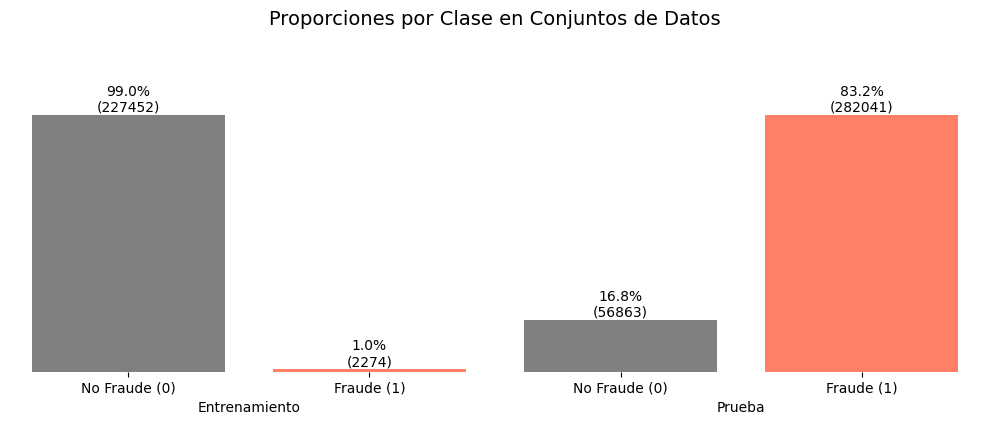

In [6]:
def get_class_stats(df):
    counts = df['Class'].value_counts().sort_index()
    proportions = counts / counts.sum() * 100
    return counts, proportions

# Obtener estadísticas
train_counts, train_props = get_class_stats(train_df)
test_counts, test_props = get_class_stats(test_df)

# Colores: gris para no fraude, rojo claro para fraude
colors = ['gray', '#ff8066']
labels = ['No Fraude (0)', 'Fraude (1)']

# Crear subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Función para dibujar cada gráfico
def plot_bar(ax, counts, proportions, title):
    bars = ax.bar(labels, proportions.values, color=colors)
    for bar, value, count in zip(bars, proportions.values, counts.values):
        ax.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.1f}%\n({count})',
                ha='center', va='bottom', fontsize=10)
    ax.set_xlabel(title)
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

# Dibujar los gráficos
plot_bar(axes[0], train_counts, train_props, 'Entrenamiento')
plot_bar(axes[1], test_counts, test_props, 'Prueba')

# Ajustar espaciado
plt.tight_layout()
plt.suptitle('Proporciones por Clase en Conjuntos de Datos', fontsize=14, y=1.05)
plt.subplots_adjust(top=0.82)
plt.show()


## **PREPARACION DE DATOS DE ENTRENAMIENTO**

In [7]:
#se define el parametro scaler global
scaler = StandardScaler()

def prepare_data_train(train_df):
    X_train = train_df.drop(columns=["Class","id"])
    y_train = train_df["Class"]

    X_train_scaled = scaler.fit_transform(X_train)
    # SMOTE solo en el entrenamiento
    smote = SMOTE(random_state=42)
    X_train_scaled_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

    return X_train_scaled, y_train, X_train_scaled_smote, y_train_smote

In [8]:
X_train_scaled,y_train, X_train_scaled_smote, y_train_smote = prepare_data_train(train_df)

V14      -0.805669
V12      -0.768579
V4        0.735981
V11       0.724278
V3       -0.682095
V10      -0.673665
V9       -0.585522
V16      -0.573511
V1       -0.505761
V2        0.491878
V7       -0.491234
V17      -0.476377
V6       -0.435088
V18      -0.410091
V5       -0.338639
V19       0.244081
V27       0.214002
V20       0.179851
V8        0.144294
V24      -0.130107
V21       0.109640
V28       0.102024
V13      -0.071105
V26       0.071052
V25       0.061847
V15      -0.037948
V22       0.014098
V23       0.010255
Amount    0.002261
Name: Class, dtype: float64


C:\Users\cristian\AppData\Local\Temp\ipykernel_18904\414112965.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations_sorted.values, y=correlations_sorted.index, palette="coolwarm")


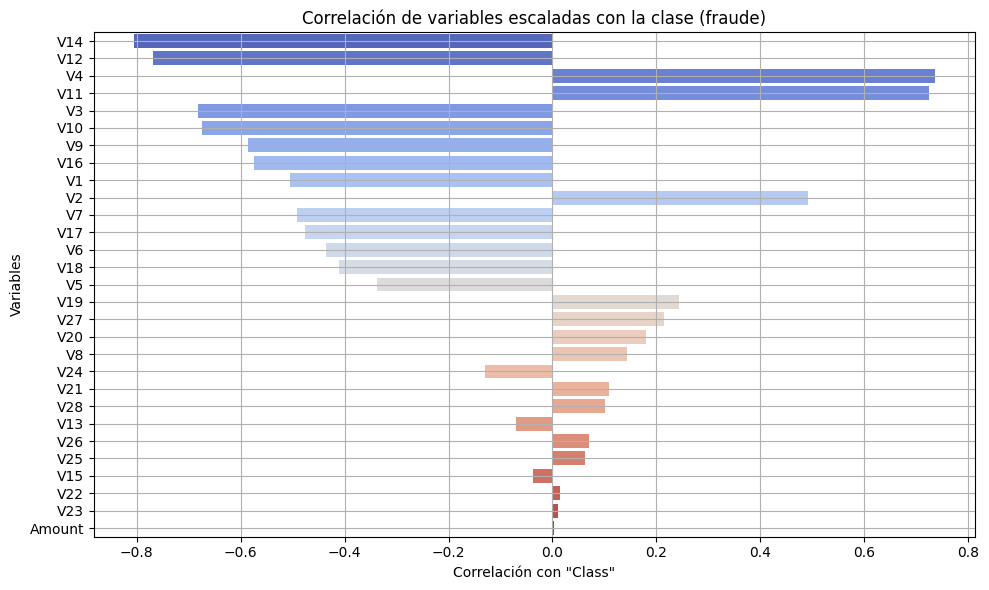

In [9]:
# Suponiendo que tu DataFrame original se llama df
# Variables a excluir
excluded_cols = ['id', 'Class']

# Separar características numéricas útiles
features = df.drop(columns=excluded_cols)

# Escalar todas las variables excepto 'id' y 'Class'
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Crear un DataFrame con los datos escalados
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)

# Añadir nuevamente la columna objetivo
scaled_df['Class'] = df['Class'].values

# Calcular correlaciones con la variable objetivo
correlations = scaled_df.corr()['Class'].drop('Class')

# Ordenar por valor absoluto
correlations_sorted = correlations.reindex(correlations.abs().sort_values(ascending=False).index)

# Mostrar resultados
print(correlations_sorted)

# Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations_sorted.values, y=correlations_sorted.index, palette="coolwarm")
plt.title('Correlación de variables escaladas con la clase (fraude)')
plt.xlabel('Correlación con "Class"')
plt.ylabel('Variables')
plt.grid(True)
plt.tight_layout()
plt.show()


Información mutua (no lineal) con la clase:

V14       0.509691
V17       0.459194
V10       0.451169
V12       0.440168
V4        0.420958
V11       0.411371
V3        0.366319
V16       0.357713
V7        0.303475
V2        0.281675
V9        0.268695
V21       0.239920
V27       0.231969
V18       0.224966
V1        0.210401
V6        0.183640
V28       0.177880
V5        0.175473
V8        0.154103
V19       0.123986
V20       0.117783
V24       0.078059
V23       0.068074
V26       0.057492
V25       0.040850
V22       0.034232
V15       0.027437
V13       0.026126
Amount    0.000000
dtype: float64


C:\Users\cristian\AppData\Local\Temp\ipykernel_18904\1064520974.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mi_series.values, y=mi_series.index, palette="viridis")


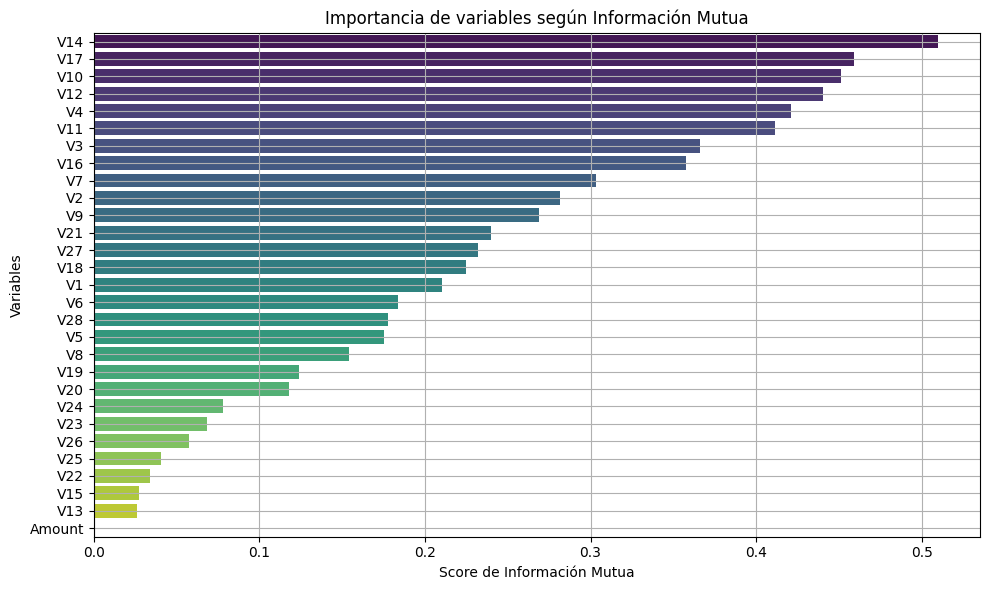

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Excluir columnas no predictoras
excluded_cols = ['id', 'Class']
features = df.drop(columns=excluded_cols)
target = df['Class']

# Escalar las variables
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)

# Calcular la información mutua (no lineal)
mi_scores = mutual_info_classif(scaled_df, target, discrete_features=False, random_state=42)

# Crear una serie ordenada
mi_series = pd.Series(mi_scores, index=scaled_df.columns).sort_values(ascending=False)

# Mostrar los resultados
print("\nInformación mutua (no lineal) con la clase:\n")
print(mi_series)

# Visualización
plt.figure(figsize=(10, 6))
sns.barplot(x=mi_series.values, y=mi_series.index, palette="viridis")
plt.title('Importancia de variables según Información Mutua')
plt.xlabel('Score de Información Mutua')
plt.ylabel('Variables')
plt.grid(True)
plt.tight_layout()
plt.show()



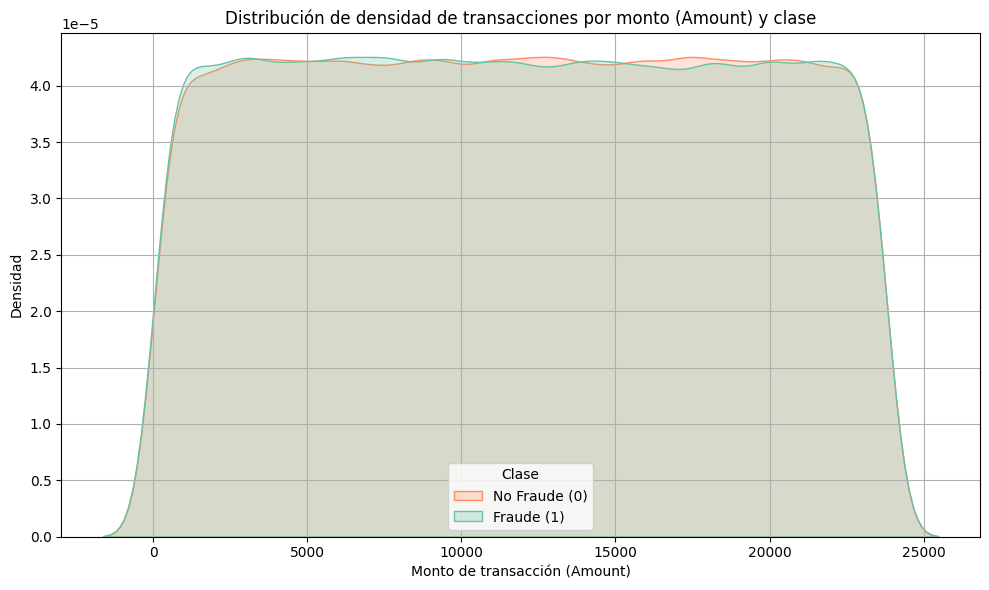

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtramos para evitar outliers extremos que distorsionen la gráfica
df_amount_filtered = df[df['Amount'] < df['Amount'].quantile(0.99)]  # 99% para limitar valores extremos

plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_amount_filtered, x='Amount', hue='Class', common_norm=False, fill=True, palette="Set2")
plt.title('Distribución de densidad de transacciones por monto (Amount) y clase')
plt.xlabel('Monto de transacción (Amount)')
plt.ylabel('Densidad')
plt.legend(title='Clase', labels=['No Fraude (0)', 'Fraude (1)'])
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\cristian\AppData\Local\Temp\ipykernel_18904\1711058711.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df_subset, x='Class', y='Amount', jitter=0.25, palette="muted")


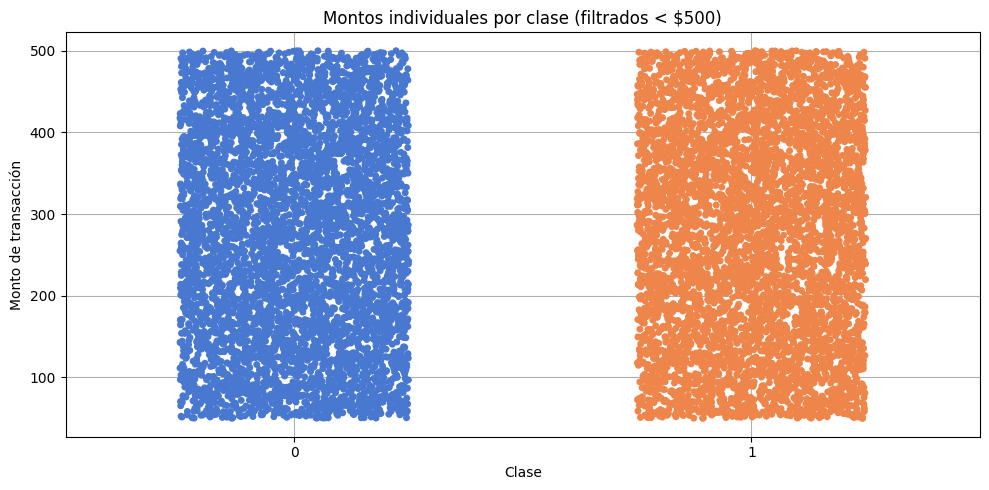

In [43]:
df_subset = df[df['Amount'] < 500]  # para reducir ruido visual

plt.figure(figsize=(10, 5))
sns.stripplot(data=df_subset, x='Class', y='Amount', jitter=0.25, palette="muted")
plt.title('Montos individuales por clase (filtrados < $500)')
plt.xlabel('Clase')
plt.ylabel('Monto de transacción')
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\cristian\AppData\Local\Temp\ipykernel_18904\3753703730.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class', y=var, data=df_filtered, palette='Set3')
C:\Users\cristian\AppData\Local\Temp\ipykernel_18904\3753703730.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class', y=var, data=df_filtered, palette='Set3')
C:\Users\cristian\AppData\Local\Temp\ipykernel_18904\3753703730.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class', y=var, data=df_filtered, palette='Set3')
C:\Users\cristian\AppData\Local\Temp\ipy

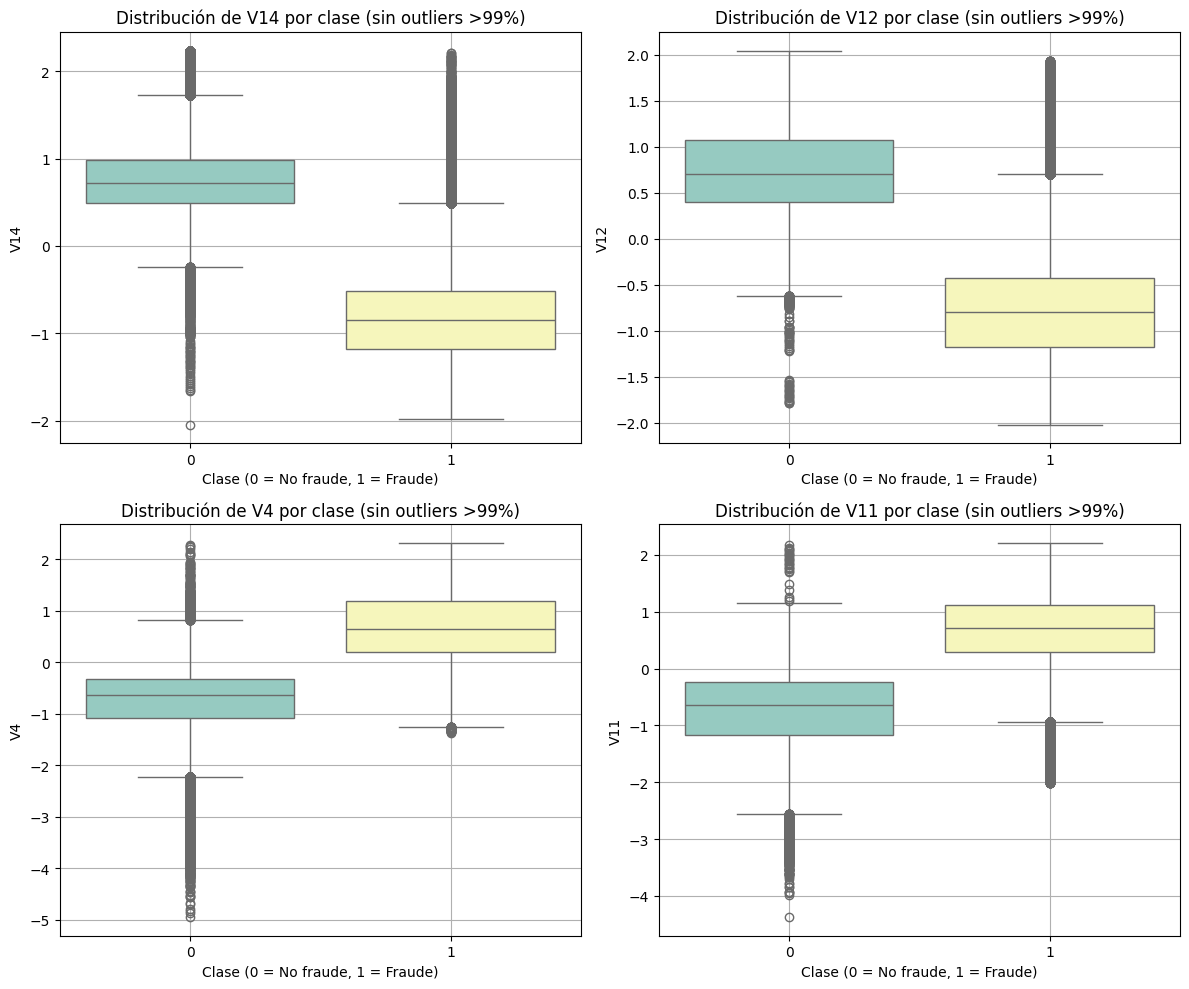

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Lista de variables a graficar
variables = ['V14', 'V12', 'V4', 'V11']

# Filtrar el dataframe eliminando outliers por encima del percentil 99 para cada variable
df_filtered = df.copy()
for var in variables:
    p99 = df_filtered[var].quantile(0.99)
    df_filtered = df_filtered[df_filtered[var] <= p99]

# Crear los boxplots
plt.figure(figsize=(12, 10))
for i, var in enumerate(variables, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='Class', y=var, data=df_filtered, palette='Set3')
    plt.title(f'Distribución de {var} por clase (sin outliers >99%)')
    plt.xlabel('Clase (0 = No fraude, 1 = Fraude)')
    plt.ylabel(var)
    plt.grid(True)

plt.tight_layout()
plt.show()


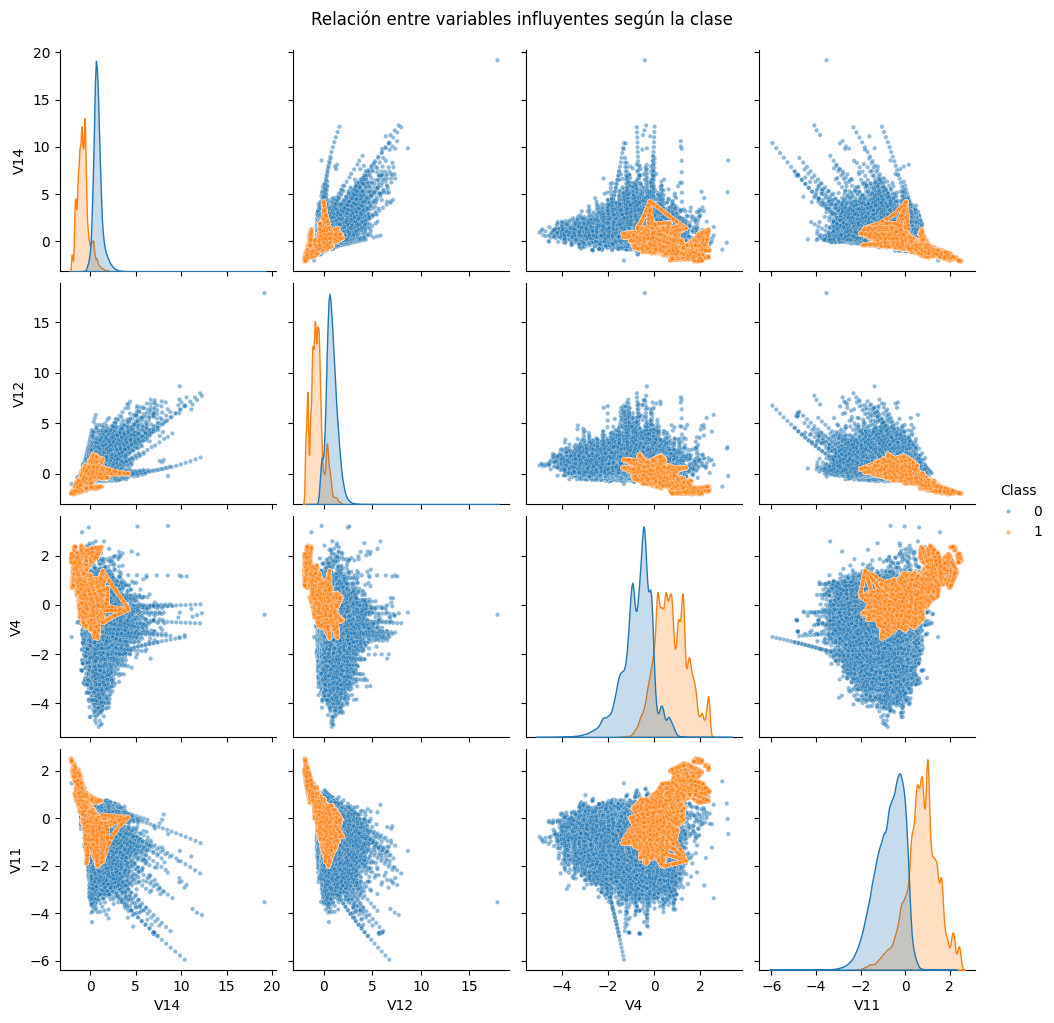

In [46]:
sns.pairplot(df, vars=['V14', 'V12', 'V4', 'V11'], hue='Class', plot_kws={'alpha': 0.5, 's': 10})
plt.suptitle('Relación entre variables influyentes según la clase', y=1.02)
plt.show()


## **ENTRENAMIENTO DE MODELOS**

In [10]:
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

**Modelos Tradicionales de Machine Learning**

RandomForestClassifier

In [11]:
rf_model = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
rf_trained = train_model(rf_model, X_train_scaled, y_train)
rf_trained_SMOTE = train_model(rf_model, X_train_scaled_smote, y_train_smote)

Logistic Regression

In [12]:
logreg = LogisticRegression(class_weight='balanced', max_iter=1000)
logreg_trained = train_model(logreg, X_train_scaled, y_train)
logreg_trained_smote = train_model(logreg, X_train_scaled_smote, y_train_smote)

XGBoost

In [13]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV


scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'min_child_weight': [1, 3, 5]
}

xgb_base = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=30,          
    scoring='f1',       
    n_jobs=-1,
    cv=3,
    verbose=1,
    random_state=42
)
xgb_search_smote = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=30,          
    scoring='f1',       
    n_jobs=-1,
    cv=3,
    verbose=1,
    random_state=42
)


xgb_search.fit(X_train_scaled, y_train) 
xgb_search_smote.fit(X_train_scaled_smote, y_train_smote)

xgb_best = xgb_search.best_estimator_
xgb_best_SMOTE = xgb_search_smote.best_estimator_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\cristian\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:38:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\cristian\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:40:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


**Deep Learning Models**

Multilayer Perceptron (MLP)

In [14]:
#mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=300)
#mlp_trained = train_model(mlp, X_train_scaled, y_train)
#mlp_trained_SMOTE = train_model(mlp, X_train_scaled_smote, y_train_smote)

In [15]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_mlp_model(hp):
    model = Sequential()
    
    model.add(Dense(
        units=hp.Int('units_input', min_value=32, max_value=256, step=32),
        activation='relu',
        input_shape=(X_train_scaled.shape[1],)
    ))
    model.add(Dropout(hp.Float('dropout_input', 0.1, 0.5, step=0.1)))
    
    if hp.Boolean("add_hidden_layer"):
        model.add(Dense(
            units=hp.Int('units_hidden', min_value=32, max_value=256, step=32),
            activation='relu'
        ))
        model.add(Dropout(hp.Float('dropout_hidden', 0.1, 0.5, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [16]:
tuner = kt.RandomSearch(
    build_mlp_model,
    objective='val_accuracy',
    max_trials=10,  # puedes ajustar esto
    executions_per_trial=1,
    overwrite=True,
    directory='mlp_tuning',
    project_name='mlp_sin_id'
)
tuner_SMOTE = kt.RandomSearch(
    build_mlp_model,
    objective='val_accuracy',
    max_trials=10,  # puedes ajustar esto
    executions_per_trial=1,
    overwrite=True,
    directory='mlp_tuning',
    project_name='mlp_sin_id2'
)


C:\Users\cristian\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

tuner.search(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)

tuner_SMOTE.search(
    X_train_scaled_smote, y_train_smote,
    validation_split=0.2,
    epochs=30,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)


Trial 10 Complete [00h 00m 40s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 05m 25s


In [18]:
#from tensorflow.keras import backend as K
#K.clear_session()

In [19]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model_smote = tuner_SMOTE.get_best_models(num_models=1)[0]

# Entrenar nuevamente si deseas con más épocas
best_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)
best_model_smote.fit(
    X_train_scaled_smote, y_train_smote,
    validation_split=0.2,
    epochs=30,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)


C:\Users\cristian\miniconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/30


C:\Users\cristian\miniconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9995 - loss: 0.0014 - val_accuracy: 0.9992 - val_loss: 0.0031
Epoch 2/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9995 - loss: 0.0014 - val_accuracy: 0.9991 - val_loss: 0.0033
Epoch 3/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9995 - loss: 0.0014 - val_accuracy: 0.9992 - val_loss: 0.0028
Epoch 4/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9995 - loss: 0.0016 - val_accuracy: 0.9992 - val_loss: 0.0027
Epoch 5/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9996 - loss: 0.0011 - val_accuracy: 0.9992 - val_loss: 0.0029
Epoch 6/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9996 - loss: 0.0012 - val_accuracy: 0.9991 - val_loss: 0.0030
Epoch 7/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9996 - loss: 0.0014 - val_accuracy: 0.9993 - val_loss: 0.0026
Epoch 8/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9996 - loss: 0.0011 - val_accuracy: 0.9993 - val_

In [69]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           3,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,909 (46.52 KB)

 Trainable params: 3,969 (15.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,940 (31.02 KB)

In [70]:
best_model_smote.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 160)                 │           4,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 160)                 │          25,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 92,165 (360.02 KB)

 Trainable params: 30,721 (120.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,444 (240.02 KB)

Convolutional Neural Networks (CNN)

In [20]:
X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_train_cnn_smote = X_train_scaled_smote.reshape((X_train_scaled_smote.shape[0], X_train_scaled_smote.shape[1], 1))

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

def build_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=2, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(64, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def build_cnn_tuned_model(hp):
    model = Sequential()

    # Primera capa Conv1D
    model.add(Conv1D(
        filters=hp.Choice('filters_1', values=[16, 32, 64]),
        kernel_size=hp.Choice('kernel_1', values=[2, 3, 5]),
        activation='relu',
        input_shape=(X_train_cnn.shape[1], 1)
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    # Segunda capa Conv1D (opcional)
    if hp.Boolean("add_second_conv"):
        model.add(Conv1D(
            filters=hp.Choice('filters_2', values=[32, 64, 128]),
            kernel_size=hp.Choice('kernel_2', values=[2, 3]),
            activation='relu'
        ))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(hp.Float('dropout_conv', 0.2, 0.5, step=0.1)))

    # Capas densas
    model.add(Flatten())
    model.add(Dense(
        hp.Choice('dense_units', values=[32, 64, 128]),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_dense', 0.2, 0.5, step=0.1)))

    # Salida
    model.add(Dense(1, activation='sigmoid'))

    # Compilación
    model.compile(
        optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [22]:
tuner_cnn = kt.RandomSearch(
    build_cnn_tuned_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='cnn_tuning',
    project_name='fraude_cnn1'
)
tuner_cnn_smote = kt.RandomSearch(
    build_cnn_tuned_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='cnn_tuning',
    project_name='fraude_cnn2'
)

Reloading Tuner from cnn_tuning\fraude_cnn1\tuner0.json
Reloading Tuner from cnn_tuning\fraude_cnn2\tuner0.json


In [23]:
tuner_cnn.search(
    X_train_cnn, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)
tuner_cnn_smote.search(
    X_train_cnn_smote, y_train_smote,
    validation_split=0.2,
    epochs=30,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',      
    patience=3,
    restore_best_weights=True
)

best_cnn_model = tuner_cnn.get_best_models(num_models=1)[0]

best_cnn_model.fit(
    X_train_cnn, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)

best_cnn_model_smote = tuner_cnn_smote.get_best_models(num_models=1)[0]

best_cnn_model_smote.fit(
    X_train_cnn_smote, y_train_smote,
    validation_split=0.2,
    epochs=30,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/30


C:\Users\cristian\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\cristian\miniconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


718/718 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9991 - loss: 0.0036 - val_accuracy: 0.9992 - val_loss: 0.0028
Epoch 2/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9993 - loss: 0.0026 - val_accuracy: 0.9994 - val_loss: 0.0023
Epoch 3/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9993 - loss: 0.0023 - val_accuracy: 0.9992 - val_loss: 0.0024
Epoch 4/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9993 - loss: 0.0021 - val_accuracy: 0.9993 - val_loss: 0.0021
Epoch 5/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9994 - loss: 0.0018 - val_accuracy: 0.9993 - val_loss: 0.0021
Epoch 6/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9994 - loss: 0.0018 - val_accuracy: 0.9992 - val_loss: 0.0024
Epoch 7/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9995 - loss: 0.0017 - val_accuracy: 0.9994 - val_loss: 0.0021
Epoch 8/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9995 - loss: 0.0015 - val_accuracy: 0.9993 - val_

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',      
    patience=3,
    restore_best_weights=True
)

cnn_model = build_cnn_model((X_train_cnn.shape[1], 1))

cnn_history = cnn_model.fit(
    X_train_cnn, y_train,
    epochs=30,                
    batch_size=256,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop]
)

cnn_model_smote = build_cnn_model((X_train_cnn_smote.shape[1], 1))

cnn_history = cnn_model_smote.fit(
    X_train_cnn_smote, y_train_smote,
    epochs=30,                
    batch_size=256,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9885 - loss: 0.0520 - val_accuracy: 0.9978 - val_loss: 0.0114
Epoch 2/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9980 - loss: 0.0101 - val_accuracy: 0.9980 - val_loss: 0.0089
Epoch 3/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9979 - loss: 0.0094 - val_accuracy: 0.9981 - val_loss: 0.0085
Epoch 4/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9985 - loss: 0.0070 - val_accuracy: 0.9978 - val_loss: 0.0086
Epoch 5/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9984 - loss: 0.0076 - val_accuracy: 0.9980 - val_loss: 0.0081
Epoch 6/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9982 - loss: 0.0077 - val_accuracy: 0.9985 - val_loss: 0.0069
Epoch 7/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9986 - loss: 0.0066 - val_accuracy: 0.9981 - val_loss: 0.0072
Epoch 8/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9985 - loss: 0.0064 - val_accuracy: 0.

**Modelos Híbridos**

ANN + SVM

In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input

def build_ann_feature_extractor(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(64, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    embeddings = Dense(32, activation='relu', name='embedding_layer')(x)
    output = Dense(1, activation='sigmoid')(embeddings)
    
    model = Model(inputs=inputs, outputs=output)
    return model


In [27]:
ann_extractor = build_ann_feature_extractor(X_train_scaled.shape[1])
ann_extractor.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

ann_extractor.fit(
    X_train_scaled, y_train,
    epochs=20,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9944 - loss: 0.0621 - val_accuracy: 0.9978 - val_loss: 0.0094
Epoch 2/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9982 - loss: 0.0086 - val_accuracy: 0.9981 - val_loss: 0.0073
Epoch 3/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9981 - loss: 0.0078 - val_accuracy: 0.9983 - val_loss: 0.0065
Epoch 4/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9984 - loss: 0.0064 - val_accuracy: 0.9984 - val_loss: 0.0060
Epoch 5/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9985 - loss: 0.0057 - val_accuracy: 0.9985 - val_loss: 0.0053
Epoch 6/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9986 - loss: 0.0051 - val_accuracy: 0.9985 - val_loss: 0.0053
Epoch 7/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9987 - loss: 0.0049 - val_accuracy: 0.9987 - val_loss: 0.0050
Epoch 8/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9988 - loss: 0.0043 - val_accuracy: 0.

In [28]:
ann_extractor_smote = build_ann_feature_extractor(X_train_scaled_smote.shape[1])
ann_extractor_smote.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

ann_extractor_smote.fit(
    X_train_scaled_smote, y_train_smote,
    epochs=20,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9553 - loss: 0.1211 - val_accuracy: 0.9915 - val_loss: 0.0262
Epoch 2/20
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9938 - loss: 0.0201 - val_accuracy: 0.9977 - val_loss: 0.0111
Epoch 3/20
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9969 - loss: 0.0116 - val_accuracy: 0.9989 - val_loss: 0.0089
Epoch 4/20
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9978 - loss: 0.0079 - val_accuracy: 0.9992 - val_loss: 0.0048
Epoch 5/20
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9984 - loss: 0.0061 - val_accuracy: 0.9998 - val_loss: 0.0031
Epoch 6/20
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9986 - loss: 0.0055 - val_accuracy: 0.9999 - val_loss: 0.0023
Epoch 7/20
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9988 - loss: 0.0047 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 8/20
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9989 - loss: 0.0044 - 

In [29]:
# Modelo intermedio que termina en la capa de embeddings
embedding_model = Model(inputs=ann_extractor.input, outputs=ann_extractor.get_layer('embedding_layer').output)
X_train_embeddings = embedding_model.predict(X_train_scaled)

7179/7179 ━━━━━━━━━━━━━━━━━━━━ 3s 463us/step


In [30]:
from sklearn.svm import SVC

svm_model = SVC(kernel='rbf', probability=True, class_weight='balanced')
svm_model.fit(X_train_embeddings, y_train)


SVC(class_weight='balanced', probability=True)

In [31]:
# Modelo intermedio que termina en la capa de embeddings
embedding_model_smote = Model(inputs=ann_extractor_smote.input, outputs=ann_extractor_smote.get_layer('embedding_layer').output)
X_train_embeddings_smote = embedding_model_smote.predict(X_train_scaled_smote)

14216/14216 ━━━━━━━━━━━━━━━━━━━━ 6s 435us/step


In [32]:
from sklearn.svm import SVC

svm_model_smote = SVC(kernel='rbf', probability=True, class_weight='balanced')
svm_model_smote.fit(X_train_embeddings_smote, y_train_smote)


SVC(class_weight='balanced', probability=True)

## **EVALUACIÓN Y TEST DE MODELOS**

In [33]:
def test_model_v2(model, test_df, true_fraud, false_fraud, model_name, is_cnn=False, preprocessor_model=None):
    if len(test_df[test_df['Class'] == 1]) < true_fraud or len(test_df[test_df['Class'] == 0]) < false_fraud:
        raise ValueError("No hay suficientes muestras disponibles para la clase solicitada.")
    
    # Selección de muestras
    fraud_test_sample = test_df[test_df['Class'] == 1].sample(n=true_fraud, random_state=42)    
    non_fraud_test_sample = test_df[test_df['Class'] == 0].sample(n=false_fraud, random_state=42)    
    test_small_df = pd.concat([fraud_test_sample, non_fraud_test_sample]).sample(frac=1, random_state=42).reset_index(drop=True)
    
    X_test = test_small_df.drop(columns=['id', 'Class'])
    y_test = test_small_df['Class']
    
    # Escalado
    X_test_scaled = scaler.transform(X_test)

    # Procesamiento según el tipo de modelo
    if preprocessor_model is not None:
        # Para ANN + SVM: aplicar red previa (embedding ANN)
        X_test_processed = preprocessor_model.predict(X_test_scaled)
        y_pred = model.predict(X_test_processed)
        y_prob = model.predict_proba(X_test_processed)[:, 1] if hasattr(model, "predict_proba") else y_pred

    elif is_cnn:
        # Para CNN u otros modelos Keras con reshape
        X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
        y_prob = model.predict(X_test_reshaped).flatten()
        y_pred = (y_prob > 0.5).astype(int)

    else:
        # Modelos tradicionales (sklearn)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else y_pred

    # Métricas
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_prob)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    return {
        "Modelo": model_name,
        "TN": tn,
        "TP": tp,        
        "FN": fn,
        "FP": fp,
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1-Score": round(f1, 3),
        "AUC-ROC": round(auc, 3)
    }


CONFIGURAR TAMAÑO DEL DATASET DE PRUEBA CON DATOS NUEVOS

In [34]:
fraudes_test_total = 1000
no_fraudes_test_total = 20000

MODELS

In [35]:
results = []

results.append(test_model_v2(svm_model, test_df, fraudes_test_total, no_fraudes_test_total, "ANN + SVM", preprocessor_model=embedding_model))
results.append(test_model_v2(svm_model_smote, test_df, fraudes_test_total, no_fraudes_test_total, "ANN + SVM (SMOTE)", preprocessor_model=embedding_model_smote))

results.append(test_model_v2(logreg_trained, test_df, fraudes_test_total, no_fraudes_test_total, "Logistic Regression"))
results.append(test_model_v2(rf_trained, test_df, fraudes_test_total, no_fraudes_test_total, "Random Forest"))
results.append(test_model_v2(best_model, test_df, fraudes_test_total, no_fraudes_test_total, "MLP", is_cnn=True))
results.append(test_model_v2(best_cnn_model, test_df, fraudes_test_total, no_fraudes_test_total, "CNN", is_cnn=True))


results.append(
    test_model_v2(
        model=xgb_best,
        test_df=test_df,
        true_fraud=fraudes_test_total,
        false_fraud=no_fraudes_test_total,
        model_name="XGBoost"
    )
)

results.append(test_model_v2(logreg_trained_smote, test_df, fraudes_test_total, no_fraudes_test_total, "Logistic Regression (SMOTE)"))
results.append(test_model_v2(rf_trained_SMOTE, test_df, fraudes_test_total, no_fraudes_test_total, "Random Forest (SMOTE)"))
results.append(test_model_v2(best_model_smote, test_df, fraudes_test_total, no_fraudes_test_total, "MLP (SMOTE)", is_cnn=True))
results.append(test_model_v2(best_cnn_model_smote, test_df, fraudes_test_total, no_fraudes_test_total, "CNN (SMOTE)", is_cnn=True))

results.append(
    test_model_v2(
        model=xgb_best_SMOTE,
        test_df=test_df,
        true_fraud=fraudes_test_total,
        false_fraud=no_fraudes_test_total,
        model_name="XGBoost (SMOTE)"
    )
)



657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 755us/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 750us/step


CONVERTIR RESULTADOS A DATAFRAME

In [36]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="FN", ascending=True).reset_index(drop=True)

results_df

,Modelo,TN,TP,FN,FP,Precision,Recall,F1-Score,AUC-ROC
0,ANN + SVM,19995,769,231,5,0.994,0.769,0.867,0.837
1,Logistic Regression,19995,731,269,5,0.993,0.731,0.842,0.993
2,Logistic Regression (SMOTE),19995,731,269,5,0.993,0.731,0.842,0.993
3,ANN + SVM (SMOTE),19995,636,364,5,0.992,0.636,0.775,0.750
4,MLP (SMOTE),19997,630,370,3,0.995,0.630,0.772,0.965
5,CNN,19999,552,448,1,0.998,0.552,0.711,0.980
6,CNN (SMOTE),20000,549,451,0,1.000,0.549,0.709,0.982
7,XGBoost (SMOTE),20000,520,480,0,1.000,0.520,0.684,0.984
8,MLP,20000,411,589,0,1.000,0.411,0.583,0.996
9,XGBoost,20000,362,638,0,1.000,0.362,0.532,0.993


## **RESUMEN DE RESULTADOS**

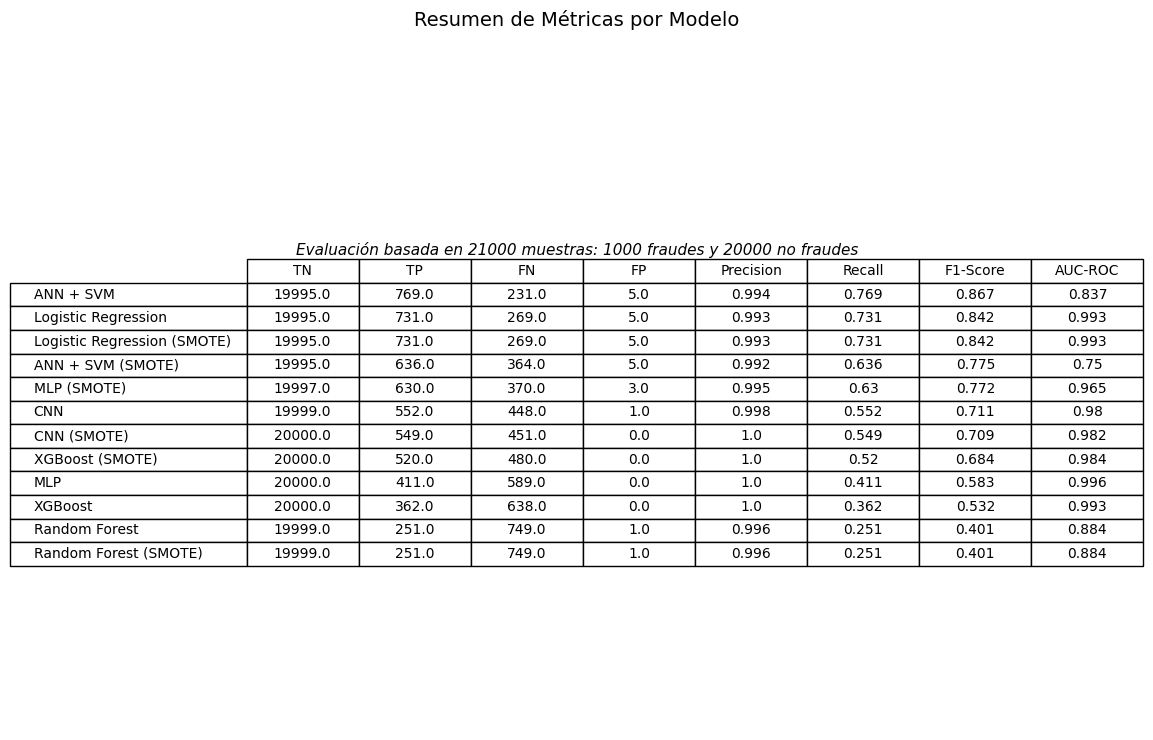

In [38]:
# Asegurar que los nombres de los modelos estén como índice
results_df_indexed = results_df.set_index("Modelo")

# Crear la figura y el eje (más ancho para tablas grandes)
fig, ax = plt.subplots(figsize=(12, len(results_df_indexed) * 0.5 + 1))
ax.axis('off')  # Quitar ejes

# Crear la tabla
ax_table = ax.table(
    cellText=results_df_indexed.values,
    colLabels=results_df_indexed.columns,
    rowLabels=results_df_indexed.index,
    cellLoc='center',
    loc='center'
)

# Ajustar fuente y escalado
ax_table.auto_set_font_size(False)
ax_table.set_fontsize(10)
ax_table.scale(1.2, 1.2)

# Título superior
plt.subplots_adjust(top=5)
fig.suptitle("Resumen de Métricas por Modelo", fontsize=14, y=1.05)
texto_muestras = f"Evaluación basada en {fraudes_test_total+no_fraudes_test_total} muestras: {fraudes_test_total} fraudes y {no_fraudes_test_total} no fraudes"
fig.text(0.5, 0.7, texto_muestras, ha='center', fontsize=11, style='italic')

# Mostrar
plt.tight_layout()
plt.show()

